# EveryBeam LOFAR HBA integration tests

These tests are all setup and explained in `test_OSKAR-MWA.ipynb`, so check that out first if you haven't already.

Goes without saying, but the test here rely on `WODEN` being compiled with `Everybeam` support.

In [1]:
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import erfa

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from wodenpy.primary_beam.use_everybeam import run_everybeam, run_everybeam_over_threads
##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

from wodenpy.array_layout.precession import RTS_Precess_LST_Lat_to_J2000

C = c.to('m/s').value

ra0 = 0
dec0 = 53

lofar_lat = 52.905329712
lofar_long = 6.867996528

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T03:35:00"
##Assume that the OSKAR telescope is near the MWA??
lofar_location = EarthLocation(lat=lofar_lat*u.deg, 
                               lon=lofar_long*u.deg)

observing_time = Time(date, scale='utc', location=lofar_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg, RA: {ra0}")

LST: 0.01862197128531748 deg, RA: 0


OK, so the most efficient way I've found of calling EveryBeam for LOFAR does not allow you to directly control the beam pointing. Instead, you have to edit the underlying Measurement Set (MS) to change the pointing. So we'll do that now.

In [2]:
from wodenpy.primary_beam.use_everybeam import create_filtered_ms

create_filtered_ms("LOFAR_HBA_MOCK.ms", "pointed_HBA.ms", np.radians(ra0), np.radians(dec0))

ms_path = "pointed_HBA.ms"

Successful readonly open of default-locked table LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful read/write open of default-locked table pointed_HBA.ms::FIELD: 10 columns, 1 rows


### Image the beam on the sky

First up, let's see if we can just plot a LOFAR station beam to check it looks sensible.

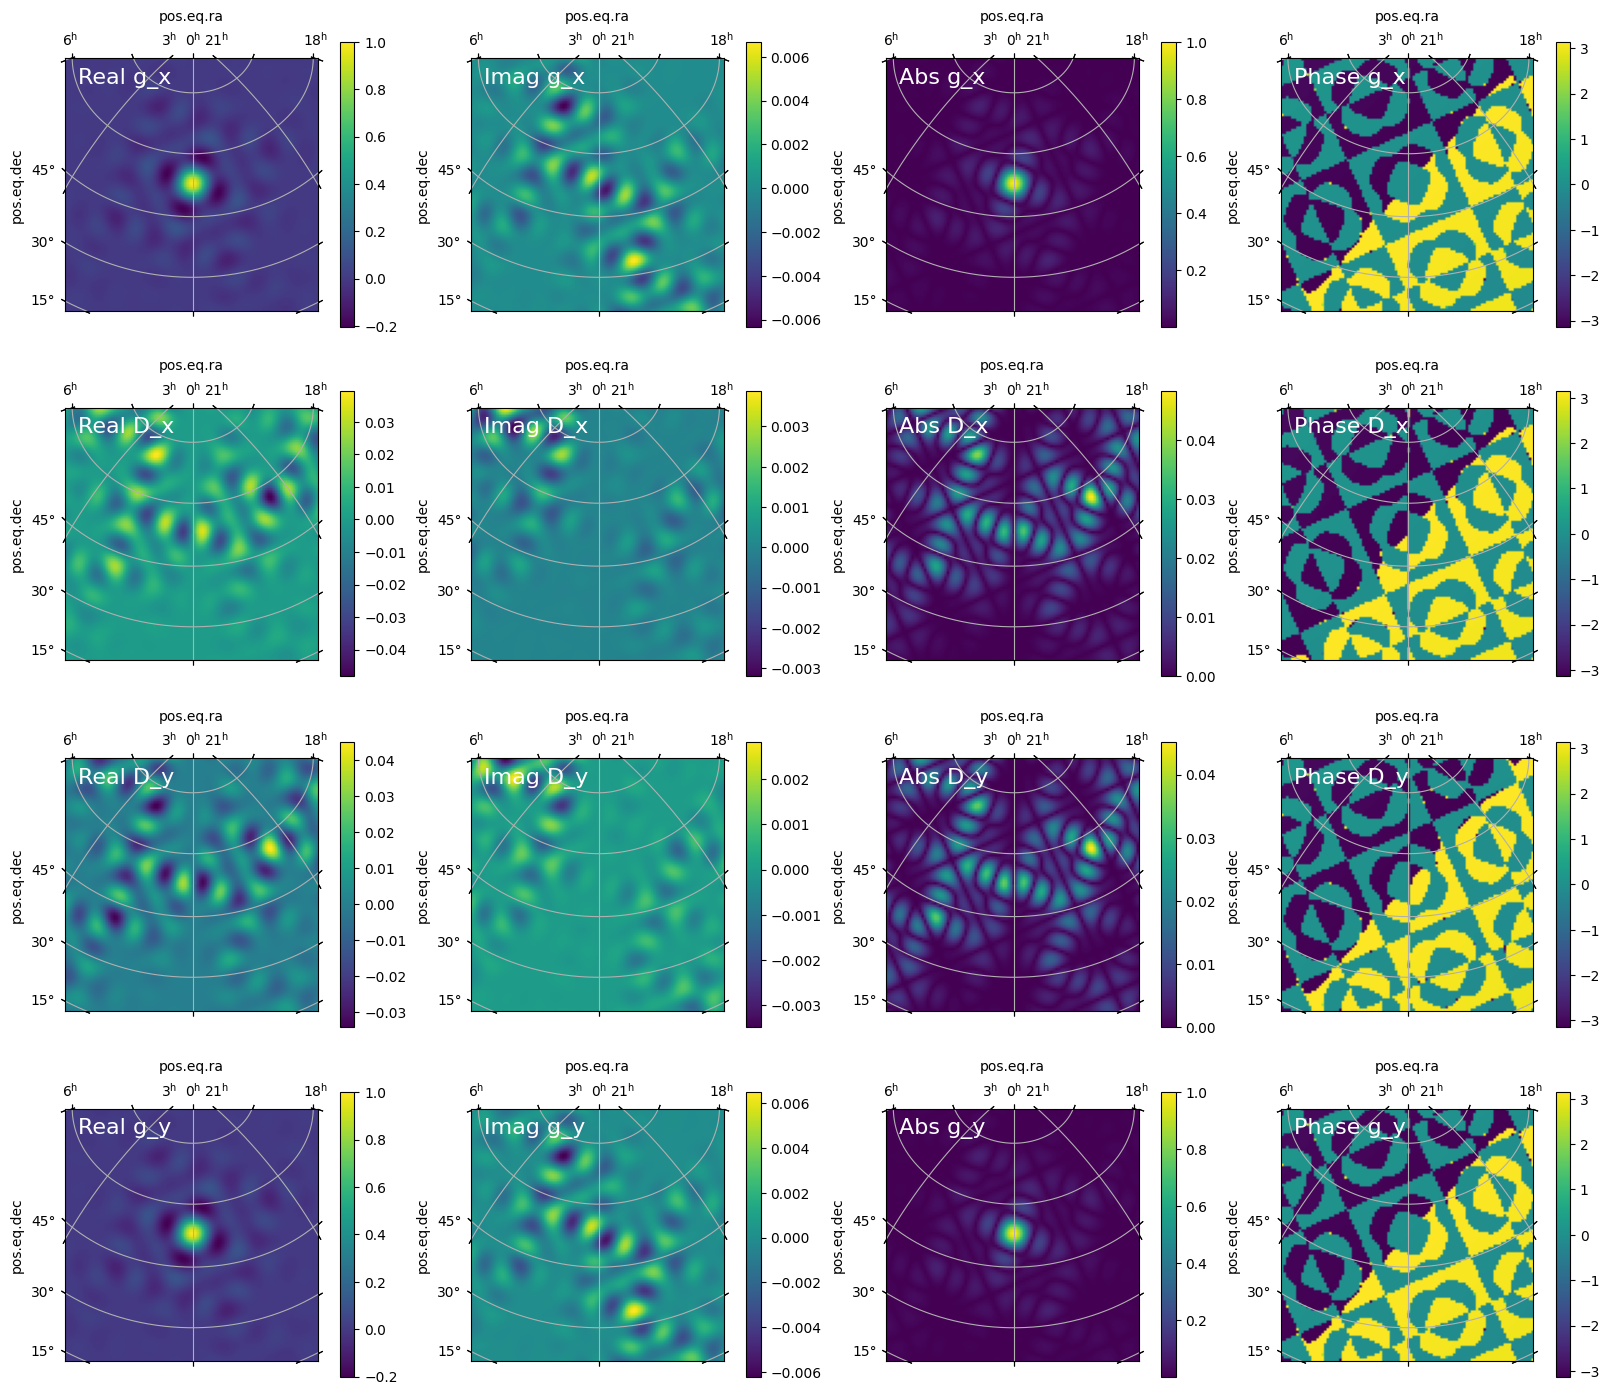

In [4]:
##setup coords
nside = 100
radec_reso = 60 / nside
header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)
ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

freq = 150e+6
station_id = 0

##Stick all our variables in lists as `run_everybeam` is designed to be
## run over multiple times/frequencies
times = [observing_time]
freqs = [freq]
station_ids = [0]

##We'll run EveryBeam in parallel to speed things up
num_threads=8

all_jones = run_everybeam_over_threads(num_threads,
                            ras, decs,
                            ms_path=ms_path,
                            times=times, freqs=freqs,
                            station_ids=station_ids,
                            beam_ra0=np.radians(ra0),
                            beam_dec0=np.radians(dec0),
                            parallactic_rotate=True)

beam_ind, time_ind, freq_ind = 0, 0, 0

all_gx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
all_Dx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
all_Dy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
all_gy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

all_gx.shape = (nside, nside)
all_Dx.shape = (nside, nside)
all_Dy.shape = (nside, nside)
all_gy.shape = (nside, nside)

plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs)

This looks decent, gains look way stronger than the leakages because I've set up the `run_everybeam` function to do a normalistion towards the beam phase centre. Same as `LOFAR LBA`, these dipoles are not aligned with the cardinal directions. The maths of all this is detailed in `test_installation/everybeam/test_LOFAR_LBA.ipynb`. We'll do the same testing here as in that notebook.

## Stokes recovery with off cardinal dipoles
Let's try to recover single point source of either Stokes I, Q, U or V.

In [5]:
make_sky_models(ra0, dec0)

freq_reso=1e+6
low_freq=100e+6
high_freq = 150e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)
primary_beam = "everybeam_LOFAR"

for pol in ['I', 'Q', 'U', 'V']:
# for pol in ['I']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    cmd = f'run_woden.py --ra0={ra0} --dec0={dec0} '
    cmd += f'--latitude={lofar_lat} --longitude={lofar_long} '
    cmd += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    cmd += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    cmd += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    cmd += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    cmd += f'--time_res=2 --num_time_steps=1 --IAU_order --num_threads=1 '
    cmd += f' --station_id=0 --off_cardinal_dipoles '
    cmd += f'--beam_ms_path=pointed_HBA.ms'

    call(cmd, shell=True)
    
# print(cmd)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table pointed_HBA.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table pointed_HBA.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table pointed_HBA.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table pointed_HBA.ms/ANTENNA: 10 columns, 70 rows
2025-10-22 14:28:09 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                 

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table pointed_HBA.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table pointed_HBA.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table pointed_HBA.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table pointed_HBA.ms/ANTENNA: 10 columns, 70 rows
2025-10-22 14:28:12 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                 

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table pointed_HBA.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table pointed_HBA.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table pointed_HBA.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table pointed_HBA.ms/ANTENNA: 10 columns, 70 rows
2025-10-22 14:28:16 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                 

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table pointed_HBA.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table pointed_HBA.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table pointed_HBA.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table pointed_HBA.ms/ANTENNA: 10 columns, 70 rows
2025-10-22 14:28:19 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                 

In [6]:
for pol in ['I', 'Q', 'U', 'V']:
    uvfits_name = f"stokes{pol}_everybeam_LOFAR"
    XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    
    test_stokes_recovery(pol, primary_beam, atol=5e-2, on_cardinal=False)
    # ##uncomment to print responses    
    # ##pick a random baseline to plot, they should all be the sam
    # baseline = 0
    # ##Supplu on_cardinal=False to use the right maths
    # recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline],
    #                                             on_cardinal=False)
    # print(f"Input {pol}, Recover I {recover_I[0].real:.2f}, Q {recover_Q[0].real:.2f}, U {recover_U[0].real:.2f}, V {recover_V[0].real:.2f}")

Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


Booya, works perfectly. Now to test the RM recovery.

## RM recovery

In [7]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

freq_reso = 0.1e+6
low_freq = 100e+6
high_freq = 130e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "everybeam_LOFAR"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--latitude={lofar_lat} --longitude={lofar_long} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order --num_threads=1 '
command += f'--station_id=0 --off_cardinal_dipoles '
command += f'--eb_point_to_phase '
command += f'--beam_ms_path=LOFAR_HBA_MOCK.ms'

call(command, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table LOFAR_HBA_MOCK.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table LOFAR_HBA_MOCK.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/test_installation/everybeam/pointed_rm_source_everybeam_LOFAR_band01.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table LOFAR_HBA_MOCK.ms/ANTENNA: 10 columns, 70 rows
2025-10-22 14:28:28 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())

0

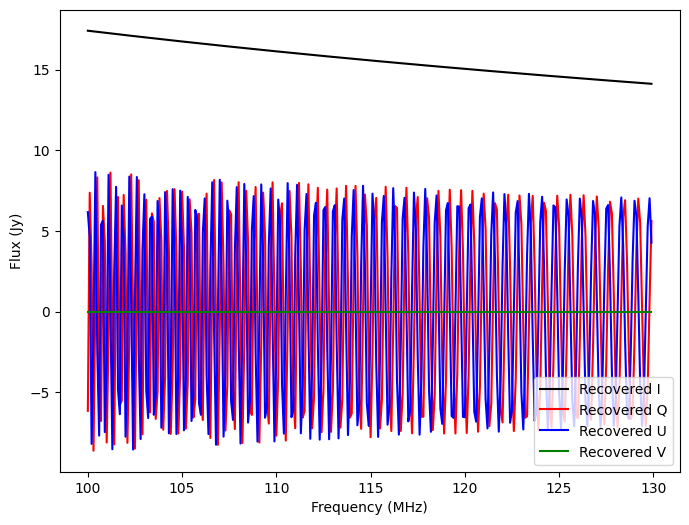

In [8]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_LOFAR_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline],
                                                                    on_cardinal=False)

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

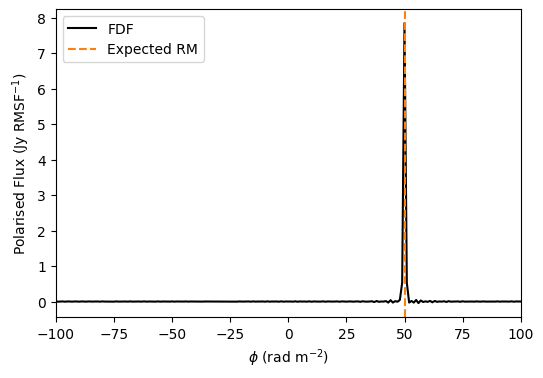

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.5 Expected Pol Fraction 0.5


In [9]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs, atol=0.02)

Looks good.

## Test unique primary beam per station

`run_everybeam` (which is called by `run_everybeam_over_threads`) has been setup to run any given number of stations, times, frequencies and directions. Here we'll test things are returned in the expecting order by running two times and two frequencies. As waiting around is boring, we'll also run things across multiple threads; this is a mircocosm of what happens in `run_woden.py`, as we split the sky model reading and beam calculations across threads. 

In [10]:
from astropy.time import TimeDelta
from wodenpy.primary_beam.use_everybeam import get_num_stations

ms_path="pointed_HBA.ms"

##Setup a grid of RA/Dec on the sky
nside=128
radec_reso = 100/nside

##lock frame to first LST, so we can see if beam is locked to RA/Dec
header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)
num_beams = get_num_stations(ms_path)

##Do a couple of frequencies to check mapping is working
all_freqs = np.array([100e+6, 150e+6])

##Do two times, 4 hours apart to check things move on the sky
##Our obs frame is locked to beam phase, so should still be centred, but it'll
##be elongated due to projection effects/pointing
all_times = np.array([observing_time, observing_time + TimeDelta(4*3600, format='sec')])

station_ids = np.arange(num_beams)

num_threads=8

##We'll run EveryBeam in parallel to speed things up
num_threads=8

all_jones = run_everybeam_over_threads(num_threads,
                            ras, decs,
                            ms_path=ms_path,
                            times=all_times, freqs=all_freqs,
                            station_ids=station_ids,
                            beam_ra0=np.radians(ra0),beam_dec0=np.radians(dec0),
                            apply_beam_norms=True,
                            iau_order=False,
                            parallactic_rotate=True)


Successful readonly open of default-locked table pointed_HBA.ms/ANTENNA: 10 columns, 70 rows


OK, now setup code to plot the the absolute values of the first polarisation for the first 36 stations, per time, per freq, to check our outputs.

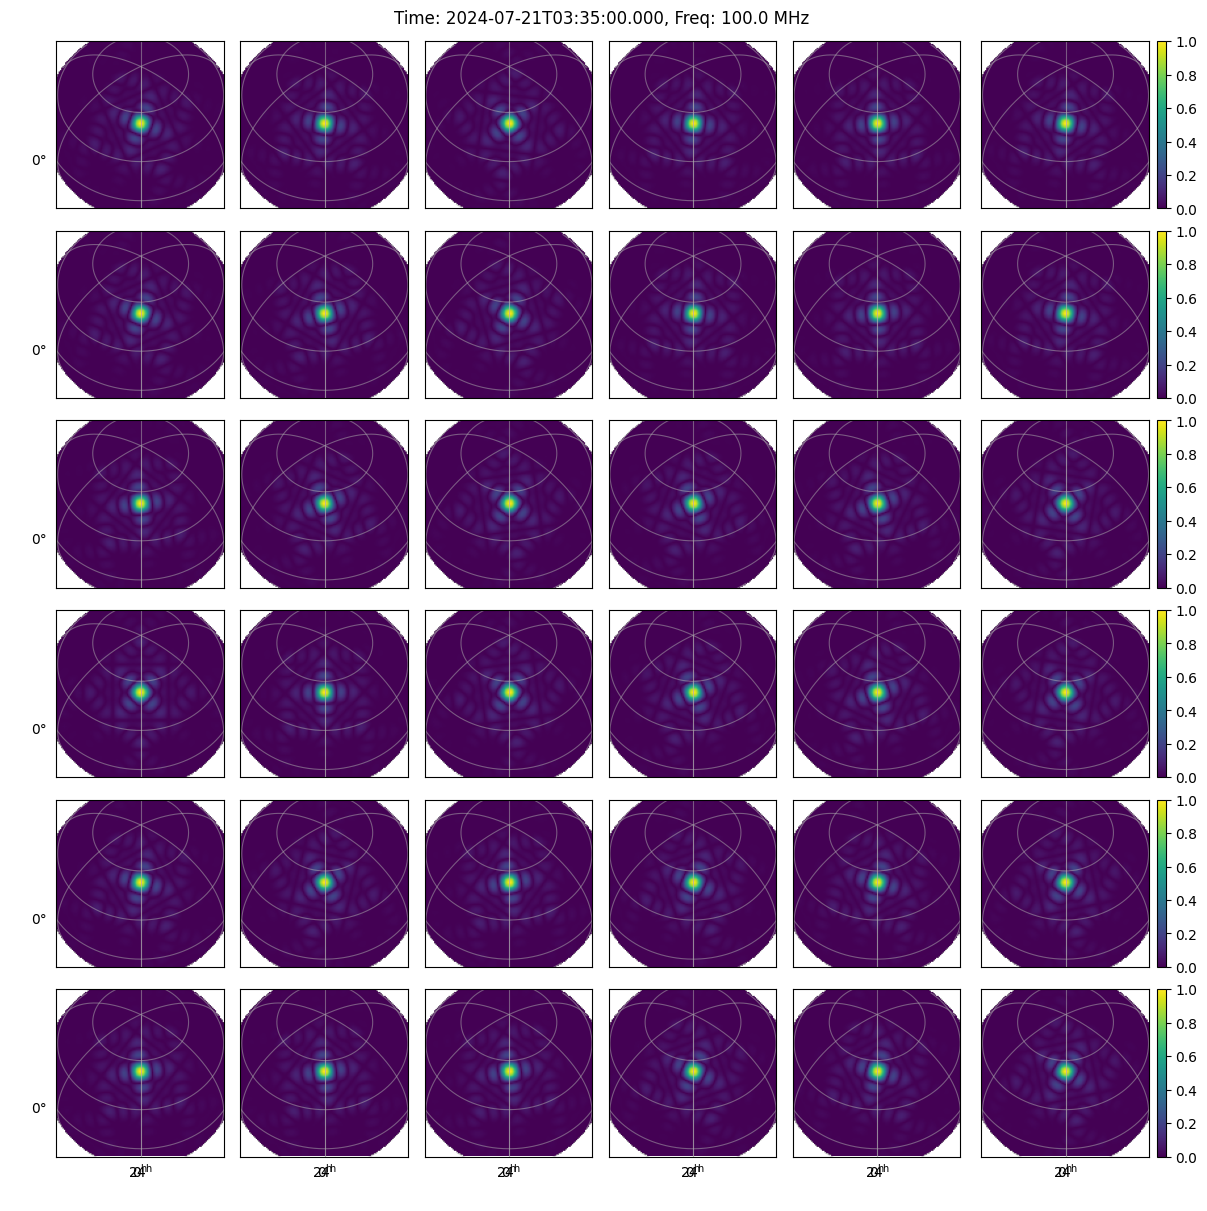

In [11]:
def plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs):
    fig, axs = plt.subplots(6, 6, figsize=(12, 12), layout='constrained',
                            subplot_kw={'projection': wcs})
    
    for col in range(6):
        for row in range(6):
            beam_ind = col*6 + row
            
            gx = all_jones[beam_ind, time_ind, freq_ind, :, 0,0]
            gx.shape = (nside, nside)
            
            im = axs[row, col].imshow(np.abs(gx), origin='lower', vmax=1, vmin=0)
            
            axs[row, col].grid(alpha=0.5)
            
            lon = axs[row, col].coords[0]
            lat = axs[row, col].coords[1]
            
            lon.set_ticks_visible(False)
            lat.set_ticks_visible(False)
            lon.set_axislabel(' ')
            lat.set_axislabel(' ')
            
            
            if col > 0:
                lat.set_ticklabel_visible(False)
            if row < 5:
                lon.set_ticklabel_visible(False)
                
            if col == 5:
                plt.colorbar(im, ax=axs[row, col])
            

    fig.suptitle(f"Time: {all_times[time_ind].isot}, Freq: {all_freqs[freq_ind]/1e+6} MHz")

    plt.show()

time_ind = 0
freq_ind = 0
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

Cool, we get a different primary beam shape for each station, they're all normalised to 1. So far so good.

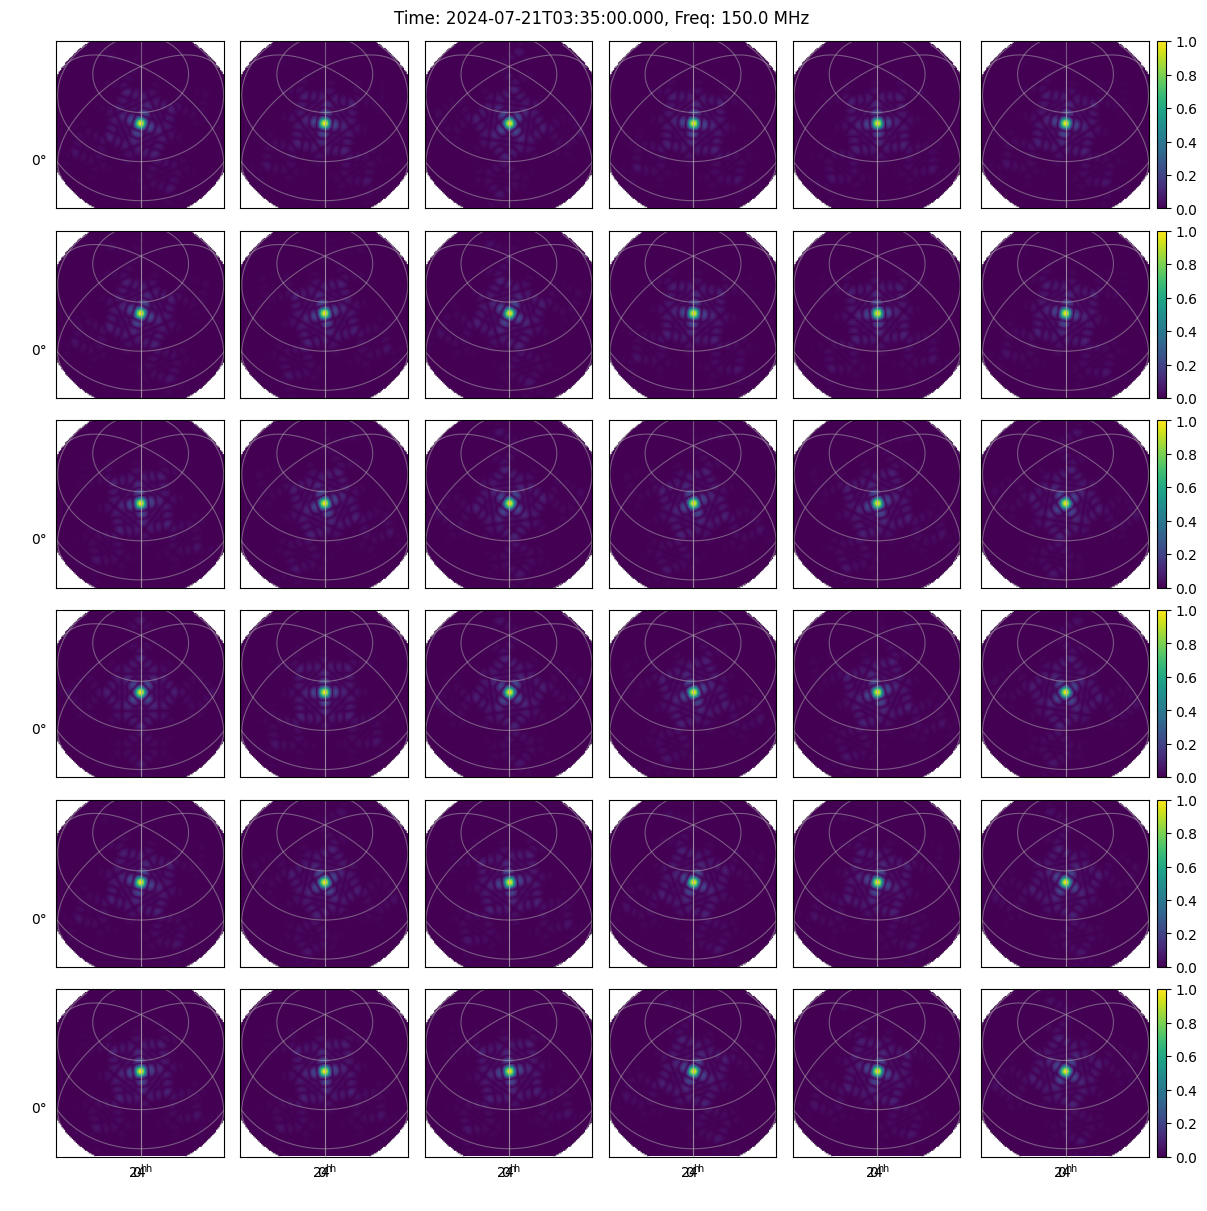

In [12]:
time_ind = 0
freq_ind = 1
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

Yup, if we switch from 100 to 150MHz the beam gets smaller on the sky, happy days.

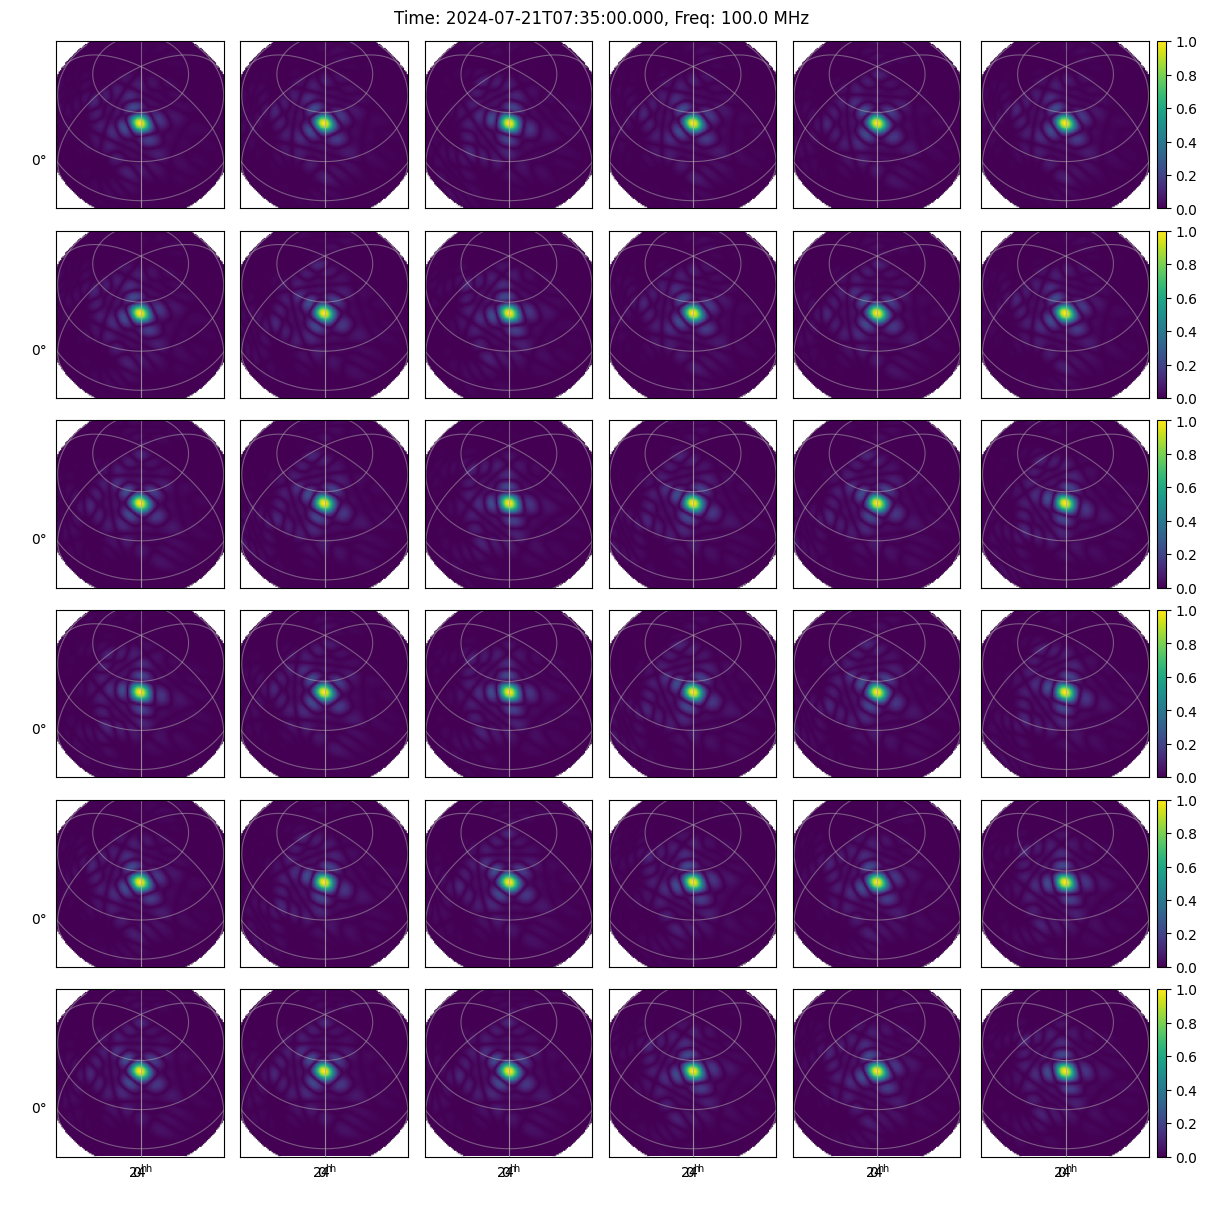

In [13]:
time_ind = 1
freq_ind = 0
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

Now we've gone from beam at zenith to 4 hours off zenith. We're still plotting with RA/Dec centred on beam, but we can see projection effects so we are defo off zenith.

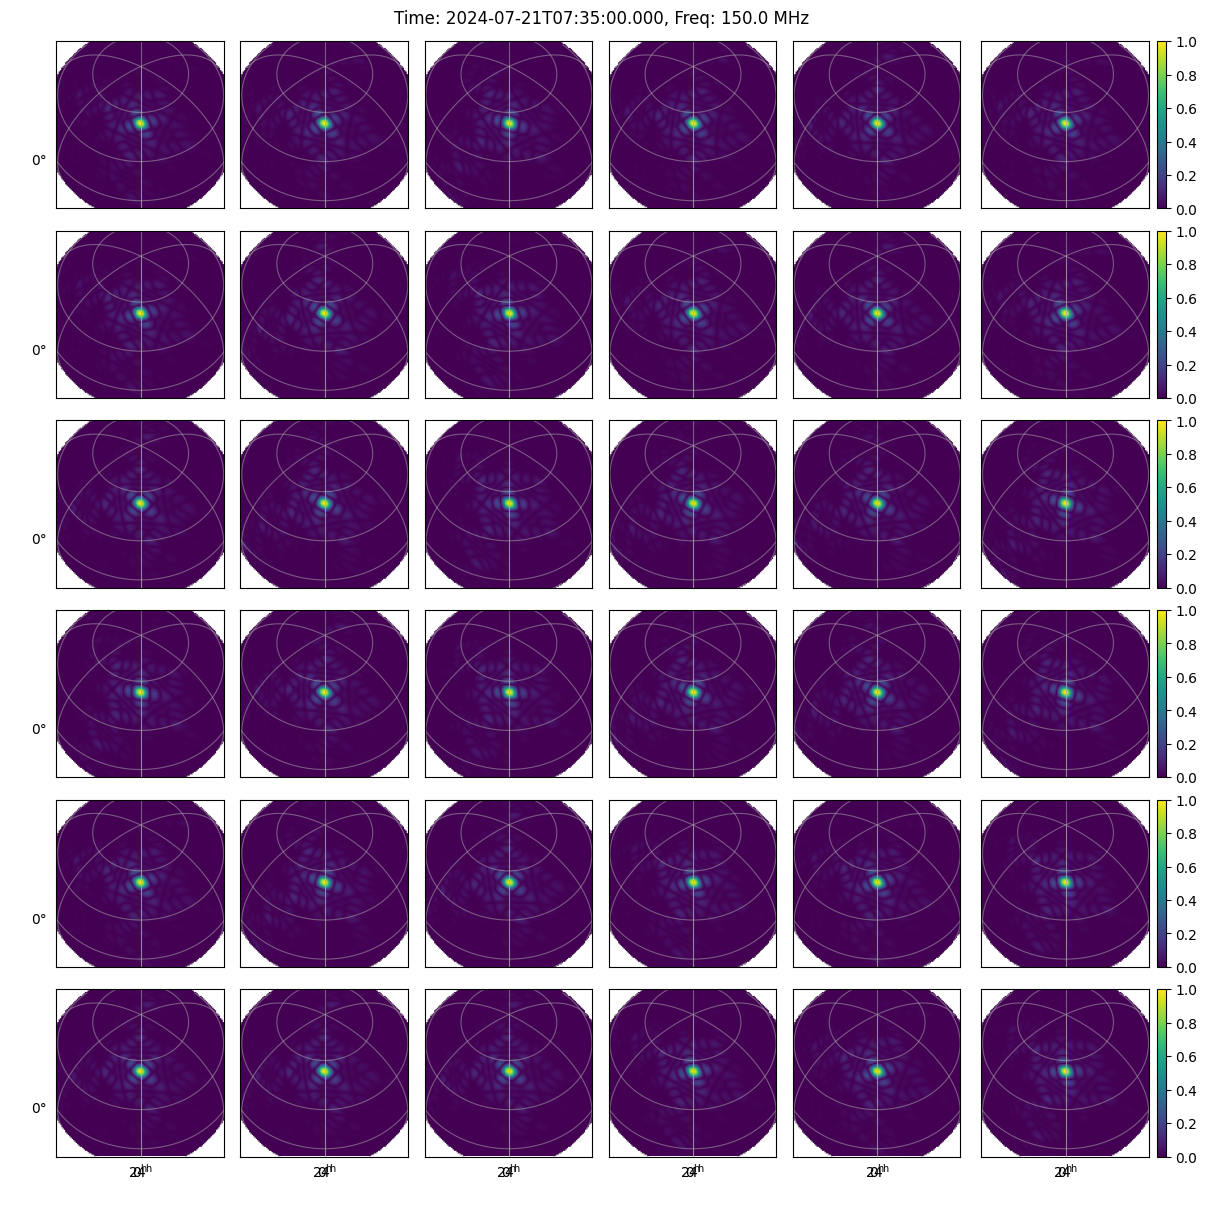

In [14]:
time_ind = 1
freq_ind = 1
plot_beam_selection(all_jones, time_ind, freq_ind, nside, wcs)

And again changing freq changes size. Things are looking good.

### Averaging over stations
As I'm an MWA person, I'm interested to see what happens to the sidelobes when we average over stations. Here we'll average over all the stations and plot a single station vs the average.

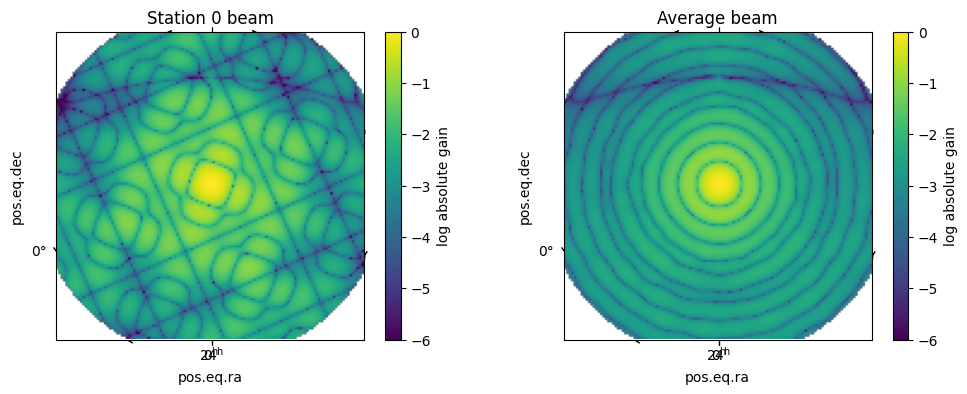

In [15]:

freq_ind, time_ind = 0, 0

all_gx = all_jones[:, time_ind, freq_ind, :, 0, 0]
all_gx.shape = (num_beams, nside, nside)

avg_beams = np.mean(all_gx, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': wcs})


im = axs[0].imshow(np.log10(np.abs(all_gx[0])), origin='lower', vmin=-6, vmax=0)
plt.colorbar(im, ax=axs[0], label='log absolute gain')
axs[0].set_title('Station 0 beam')

im = axs[1].imshow(np.log10(np.abs(avg_beams)), origin='lower', vmin=-6, vmax=0)
plt.colorbar(im, ax=axs[1], label='log absolute gain')
axs[1].set_title('Average beam')

plt.show()

Huh cool, essentially turns into an airy disk.

## Check positions of components via image
Let's bung a grid of RA/Dec through the whole simulation code, so multiple frequencies and time steps. This should check we're calling the above beam code correctly and integrating things into the code proper.

In [16]:
from astropy.table import Column, Table

nside=11
half_width = 2

ras = np.linspace(ra0 - half_width, ra0 + half_width, nside)
decs = np.linspace(dec0 - half_width, dec0 + half_width, nside)

ras, decs = np.meshgrid(ras, decs)

ras = ras.flatten()
decs = decs.flatten()

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

cat_name = 'check_positions.fits'

main_table.write(cat_name, format='fits', overwrite=True)

In [17]:
args = []

primary_beam="everybeam_LOFAR"
low_freq=130e+6
num_freq_chans=100
freq_reso=1e+4
uvfits_name=f"check_positions_{primary_beam}"

##The command to run WODEN
cmd = f'run_woden.py --ra0={ra0} --dec0={dec0} --latitude={lofar_lat} --longitude={lofar_long} '
cmd += f'--date={date} --output_uvfits_prepend={uvfits_name} --cat_filename=check_positions.fits '
cmd += f'--primary_beam={primary_beam} --lowest_channel_freq={low_freq} --freq_res={freq_reso} '
cmd += f'--num_freq_channels={num_freq_chans} --band_nums=1 --time_res=10 --num_time_steps=10 '
cmd += f'--IAU_order --num_threads=8 --station_id=0 --beam_ms_path=pointed_HBA.ms'

call(cmd, shell=True)


/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')


Successful readonly open of default-locked table pointed_HBA.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table pointed_HBA.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table pointed_HBA.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table pointed_HBA.ms/ANTENNA: 10 columns, 70 rows
2025-10-22 14:31:14 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                 

0

In [18]:
cmd = "woden_uv2ms.py "
cmd += "  --uvfits_prepend=check_positions_everybeam_LOFAR_band "
cmd += "  --band_nums=1  "

call(cmd, shell=True)

cmd = "wsclean -name check_positions_everybeam_LOFAR -size 2048 2048 -niter 2000 "
cmd += "  -auto-threshold 0.5 -auto-mask 3 "
cmd += "  -pol I -multiscale -weight briggs 0 -scale 0.002 -j 12 -mgain 0.85 "
cmd += "  -no-update-model-required "
cmd += "  check_positions_everybeam_LOFAR_band*.ms "


# print(cmd)
call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.6.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 60.72104657388263 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 60.72104657388263 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assum


WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  130-131 (100)
Reordering check_positions_everybeam_LOFAR_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for check_positions_everybeam_LOFAR_band01.ms
Detected 62.7 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for check_positions_everybeam_LOFAR_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[2.72562e-05:112.589] lambdas, maxuvw

0

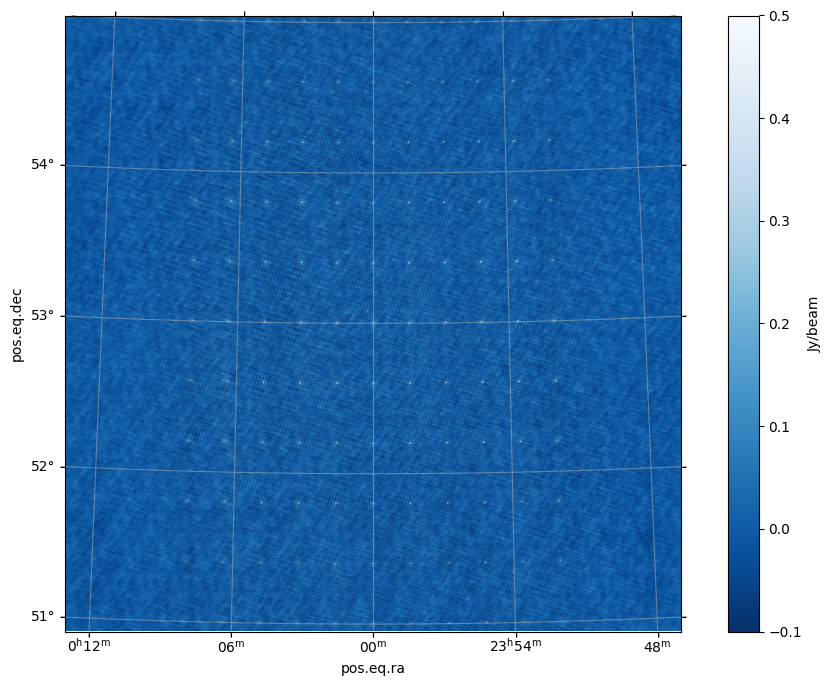

In [19]:

with fits.open('check_positions_everybeam_LOFAR-image.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=-0.1, vmax=0.5)
plt.colorbar(im, ax=axs, label='Jy/beam')

plt.grid(alpha=0.5)

plt.show()

Fairly ratty image, but we defo have a grid of point source aligned with the celestial sphere, so we're looking fine. I think `lba.MS` is a minimal example of the LBA array so the $uv$ coverage probably isn't great. Actually we can have a look at that:

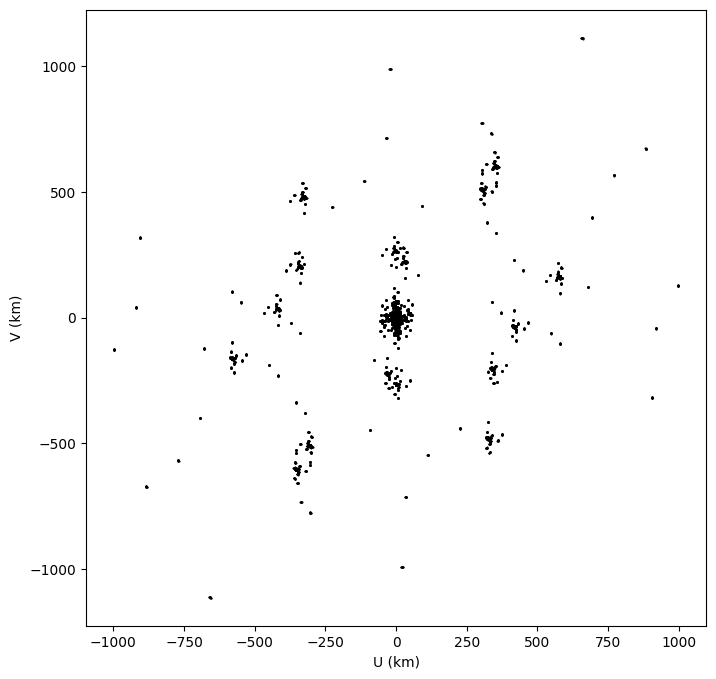

In [20]:
with fits.open('check_positions_everybeam_LOFAR_band01.uvfits') as hdu:
    uu = (hdu[0].data['UU']*c)/1e+3
    vv = (hdu[0].data['VV']*c)/1e+3
    
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.plot(uu, vv, 'k.', ms=1)
axs.plot(-uu, -vv, 'k.', ms=1)
axs.set_xlabel('U (km)')
axs.set_ylabel('V (km)')

plt.show()

Yeah pretty patchy coverage. Amazing resolution though, blimey!